In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./data/dl-pfe-ns.csv')
X = df.drop('throughput',axis=1)
y = df['throughput']

---

In [3]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate model (with cross-validation)
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],max_iter=1000000,cv=10)

In [4]:
model.fit(X_train, y_train)

ElasticNetCV(cv=10, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             max_iter=1000000)

In [5]:
model.l1_ratio_

0.9

In [6]:
model.alpha_

0.06560119677225786

In [7]:
y_pred = model.predict(X_test)

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)

In [10]:
mae

3.150251917012821

In [11]:
mse

17.041809153478077

In [12]:
rmse

4.128172616724993

In [13]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=['EN'])
err_df

,EN
MAE,3.150252
MSE,17.041809
RMSE,4.128173


In [14]:
err_df.to_csv('./cv-err/en-test-err.csv')

In [15]:
y_pred_df = pd.DataFrame(y_pred, columns=['throughput_pred'])
y_pred_df.describe().drop('count')
# no negative predictions

,throughput_pred
mean,13.501620
std,5.766513
min,-1.182753
25%,9.020273
50%,13.198802
75%,17.935505
max,26.298316


<AxesSubplot:ylabel='Count'>

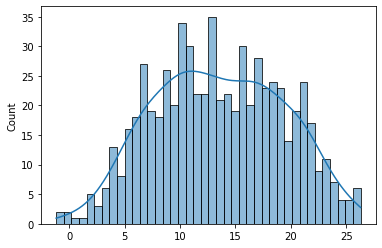

In [16]:
sns.histplot(y_pred,bins=40,kde=True)
# the distribution better reflects the true distribution of the data set

In [17]:
res = y_test - y_pred
res.describe().drop('count')

mean    -0.071360
std      4.130720
min    -14.614435
25%     -2.724584
50%     -0.299611
75%      2.334185
max     16.297538
Name: throughput, dtype: float64

Text(0.5, 0, 'Residuals')

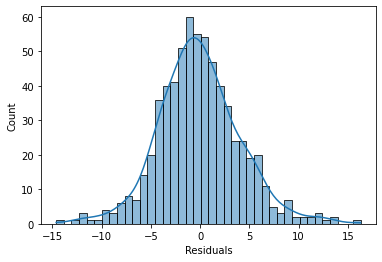

In [18]:
sns.histplot(data=res, kde=True,bins=40)
plt.xlabel('Residuals')

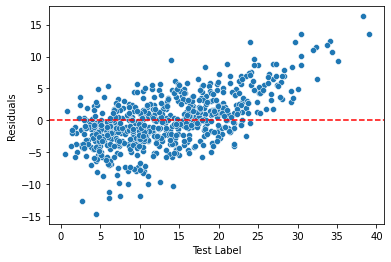

In [19]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

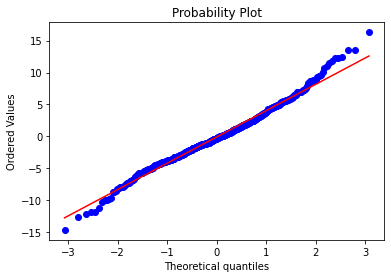

In [20]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

---

In [40]:
scaler = StandardScaler()
scaler.fit(X)

X_en = scaler.transform(X)

# Instantiate model
en_model = ElasticNetCV(
    alphas = [model.alpha_],
    l1_ratio = [model.l1_ratio_]
)
en_model.fit(X_en,y)

ElasticNetCV(alphas=[0.06560119677225786], l1_ratio=[0.9])

In [41]:
y_pred_en = en_model.predict(X_en)

<AxesSubplot:ylabel='Count'>

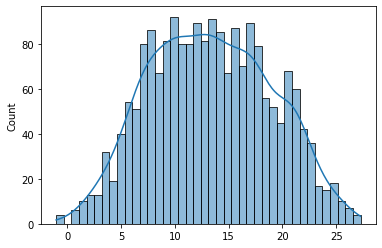

In [42]:
sns.histplot(y_pred_en,bins=40,kde=True)

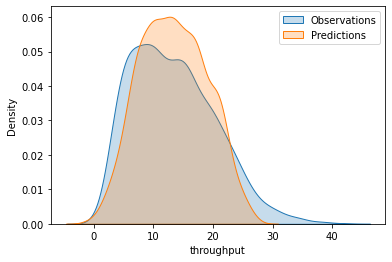

In [43]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred_en, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

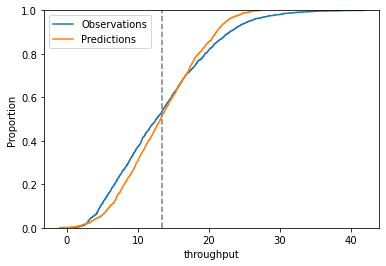

In [44]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred_en, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [45]:
mae = mean_absolute_error(y,y_pred_en)
mse = mean_squared_error(y,y_pred_en)
rmse = np.sqrt(mse)

In [46]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=['EN (alpha=0.1, l1_ratio=1)'])
err_df

,"EN (alpha=0.1, l1_ratio=1)"
MAE,3.031201
MSE,15.856876
RMSE,3.982069


In [47]:
err_df.to_csv('./model-err/en-model-err.csv')

In [48]:
from joblib import dump, load
dump(en_model, './models/en-model.joblib')

['./models/en-model.joblib']

DONE!